# **Cloud Threat Detection using LSTM Model**

In [6]:
%reload_ext tensorboard

## **1. Importing Libraries**

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping  # to stop model training on conditions
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## **2. Loading, Cleaning and Preprocessing of Data**

In [13]:
# Load timestamped CPU utilization data and preprocess the data
data = pd.read_csv('aws_ec2_instance_metric_cpu_utilization_daily.csv')

# timestamp column is converted to datetime format and set as index for time based analysis
data['timestamp'] = pd.to_datetime(data['timestamp'])  
data.set_index('timestamp', inplace=True)

In [14]:
# Use only 'maximum' column for prediction
data = data[['maximum']]   # It represents  maximum CPU Utilization
data = data.resample('D').mean()  # data is resampled on daily basis 
data = data.fillna(method='ffill')
print(data.head(30))

                             maximum
timestamp                           
2022-12-21 00:00:00+00:00  11.750392
2022-12-22 00:00:00+00:00  11.750392
2022-12-23 00:00:00+00:00  11.750392
2022-12-24 00:00:00+00:00  11.750392
2022-12-25 00:00:00+00:00  11.750392
2022-12-26 00:00:00+00:00  11.750392
2022-12-27 00:00:00+00:00  11.825197
2022-12-28 00:00:00+00:00   3.274891
2022-12-29 00:00:00+00:00   3.274891
2022-12-30 00:00:00+00:00   3.274891
2022-12-31 00:00:00+00:00   3.274891
2023-01-01 00:00:00+00:00   3.274891
2023-01-02 00:00:00+00:00   3.274891
2023-01-03 00:00:00+00:00   3.274891
2023-01-04 00:00:00+00:00   3.274891
2023-01-05 00:00:00+00:00   3.274891
2023-01-06 00:00:00+00:00   3.274891
2023-01-07 00:00:00+00:00   3.274891
2023-01-08 00:00:00+00:00  24.333333
2023-01-09 00:00:00+00:00  56.000000
2023-01-10 00:00:00+00:00  23.666667
2023-01-11 00:00:00+00:00  23.666667
2023-01-12 00:00:00+00:00  23.666667
2023-01-13 00:00:00+00:00  23.666667
2023-01-14 00:00:00+00:00  28.700000
2

C:\Users\Dell\AppData\Local\Temp\ipykernel_20400\1006360479.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


* #### **Normalization of Data**

In [15]:
# Normalize the data
scaler = MinMaxScaler()  # used to scale the data between 0 and 1 
data_scaled = scaler.fit_transform(data)

* #### **Seperating dataset with validation**

In [16]:
# Split the dataset into training, validation, and test sets
train_size = int(len(data) * 0.8)
val_size = int(len(data) * 0.1)
test_size = len(data) - train_size - val_size

train_data, val_data, test_data = (
    data_scaled[:train_size],
    data_scaled[train_size:train_size + val_size],
    data_scaled[train_size + val_size:],
)

In [18]:
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

In [7]:
# Create sequences for training, validation, and test sets
look_back = 25
X_train, y_train = create_sequences(train_data, look_back)
X_val, y_val = create_sequences(val_data, look_back)
X_test, y_test = create_sequences(test_data, look_back)

## **3. LSTM Model**

In [19]:
model = Sequential()
model.add(LSTM(200, input_shape=(look_back, 1), return_sequences=True))  # return sequences to stack
model.add(Dropout(0.2))  # Add dropout between layers to reduce overfitting
model.add(LSTM(200))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=['mse'], run_eagerly = True)

In [20]:
# Train the model on the training and validation data with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=2)

Epoch 1/100


d:\Dotslash\dotslash\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4/4 - 1s - loss: 0.0826 - mse: 0.0826 - val_loss: 0.8318 - val_mse: 0.8318 - 695ms/epoch - 174ms/step
Epoch 2/100
4/4 - 1s - loss: 0.0629 - mse: 0.0629 - val_loss: 0.5907 - val_mse: 0.5907 - 643ms/epoch - 161ms/step
Epoch 3/100
4/4 - 1s - loss: 0.0455 - mse: 0.0455 - val_loss: 0.3705 - val_mse: 0.3705 - 699ms/epoch - 175ms/step
Epoch 4/100
4/4 - 1s - loss: 0.0313 - mse: 0.0313 - val_loss: 0.1790 - val_mse: 0.1790 - 649ms/epoch - 162ms/step
Epoch 5/100
4/4 - 1s - loss: 0.0236 - mse: 0.0236 - val_loss: 0.0529 - val_mse: 0.0529 - 624ms/epoch - 156ms/step
Epoch 6/100
4/4 - 1s - loss: 0.0231 - mse: 0.0231 - val_loss: 0.0167 - val_mse: 0.0167 - 633ms/epoch - 158ms/step
Epoch 7/100
4/4 - 1s - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0262 - val_mse: 0.0262 - 618ms/epoch - 154ms/step
Epoch 8/100
4/4 - 1s - loss: 0.0237 - mse: 0.0237 - val_loss: 0.0572 - val_mse: 0.0572 - 624ms/epoch - 156ms/step
Epoch 9/100
4/4 - 1s - loss: 0.0221 - mse: 0.0221 - val_loss: 0.0872 - val_mse: 0.0872 - 643ms/epoch

In [21]:
# Make predictions on the test data
y_pred = model.predict(X_test)
# y_pred = y_pred.reshape(-1, 1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred.reshape(-1)

# Calculate RMSE on the test data
rmse = np.sqrt(mean_squared_error(data[train_size + val_size + look_back:], y_pred))
print(f'Root Mean Squared Error (RMSE) on Test Data: {rmse}')

# Define actual_data
actual_data = data[train_size + look_back:]

1/1 [==============================] - 0s 41ms/step
Root Mean Squared Error (RMSE) on Test Data: 1.6984957914474208


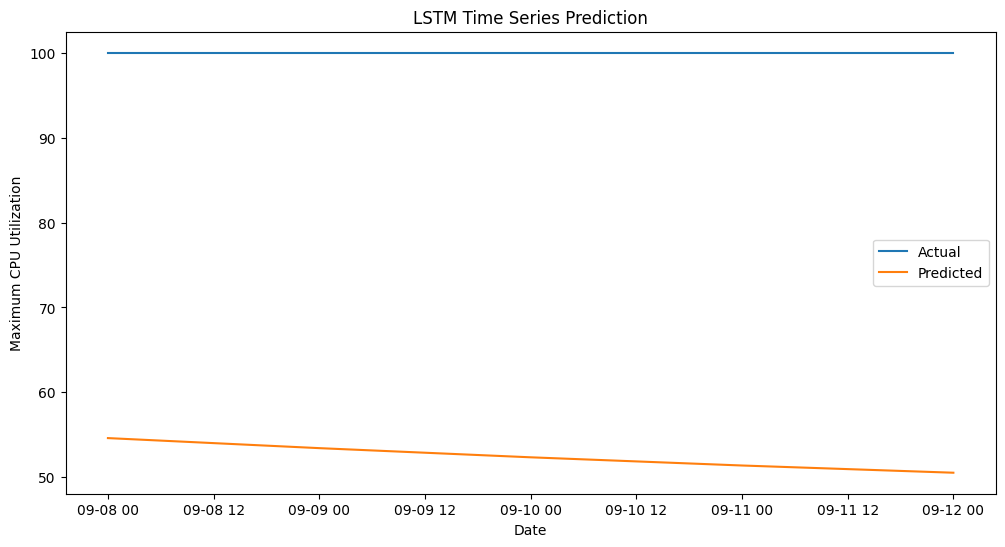

In [22]:
# Check if actual_data and y_pred have matching lengths
if len(actual_data) != len(y_pred):
    actual_data = actual_data[:len(y_pred)]


# Plot the data
date_range = data.index[train_size + look_back:train_size + look_back + len(y_pred)]

plt.figure(figsize=(12, 6))
plt.plot(date_range, actual_data, label='Actual')
plt.plot(date_range, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Maximum CPU Utilization')
plt.legend()
plt.title('LSTM Time Series Prediction')
plt.show()